# Predictive Modeling of BJJ Matches using BJJ Heroes Scraped Data

Load General Packages that will be used for the majority of the workbook

In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from time import sleep
import time
from datetime import datetime
import re
from fnmatch import fnmatch
import timeit
from datetime import date
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
import seaborn as sns
from IPython.display import display
pd.options.display.max_columns = None

Below is the code and packages necessary for scraping. With over 1,000 fighters on BJJ Heroes, Selenium is a suboptimal scraping method. But given Selenium familiarity and existing code, I chose to implement a Selenium based scrape. Data only needs to be scraped once, so the data will be stored on CSVs locally

An alternative would be to use Scrapy

In [2]:
# Load fighter and fight details from csvs
fight_df = pd.read_csv('/Users/chrismorehouse/Desktop/fight_df.csv')
fighter_df = pd.read_csv('/Users/chrismorehouse/Desktop/fighter_df.csv')
fight_df_clean = fight_df.copy()

Begin looking into data and cleaning process

In [3]:
fight_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20081 entries, 0 to 20080
Data columns (total 18 columns):
Unnamed: 0          20081 non-null int64
competition         20061 non-null object
cum_draw            20081 non-null int64
cum_loss            20081 non-null int64
cum_win             20081 non-null int64
draw                20081 non-null int64
fight_num           20081 non-null int64
fighter_name        20081 non-null object
fighter_nickname    5386 non-null object
loss                20081 non-null int64
method              19476 non-null object
opponent            20023 non-null object
stage               19935 non-null object
team                18575 non-null object
weight              20017 non-null object
win                 20081 non-null int64
win_loss            20081 non-null object
year                20081 non-null object
dtypes: int64(8), object(10)
memory usage: 2.8+ MB


In [4]:
fight_df_clean.head(10)

,Unnamed: 0,competition,cum_draw,cum_loss,cum_win,draw,fight_num,fighter_name,fighter_nickname,loss,method,opponent,stage,team,weight,win,win_loss,year
0,0,Kakuto 5,0,1,0,0,1,Aaron Johnson,Tex,1,Inside heel hook,Quentin Rosensweig,SPF,Unity JJ,ABS,0,L,2015
1,1,NY Summer Open,0,1,1,0,2,Aaron Johnson,Tex,0,Toe hold,Vitor Schlosser,SF,Unity JJ,94KG,1,W,2015
2,2,NY Summer Open,0,1,2,0,3,Aaron Johnson,Tex,0,Straight ankle lock,Ricardo Bastos,F,Unity JJ,94KG,1,W,2015
3,3,NoGi Pan Ams,0,2,2,0,4,Aaron Johnson,Tex,1,RNC,Neiman Gracie,SF,Unity JJ,94KG,0,L,2015
4,4,Kakuto Challenge,0,3,2,0,5,Aaron Johnson,Tex,1,Heel hook,Richie Martinez,SF,Unity JJ,ABS,0,L,2015
5,5,Grappling Ind.,0,3,3,0,6,Aaron Johnson,Tex,0,Points,Joseph Cashin,SF,Unity JJ,ABS,1,W,2016
6,6,Grappling Ind.,0,3,4,0,7,Aaron Johnson,Tex,0,Points,Gordon Ryan,F,Unity JJ,ABS,1,W,2016
7,7,Atlanta W. Open,0,4,4,0,8,Aaron Johnson,Tex,1,Points,Leo Nogueira,SF,Unity JJ,94KG,0,L,2016
8,8,UAEJJF NYC Pro,0,4,5,0,9,Aaron Johnson,Tex,0,Straight ankle lock,Wellington Peroto,4F,Unity JJ,94KG,1,W,2016
9,9,UAEJJF NYC Pro,0,5,5,0,10,Aaron Johnson,Tex,1,NaN,Romulo Azevedo,SF,Unity JJ,94KG,0,L,2016


Clean Submission Data

In [5]:
# start cleaning up submission types
fight_df_clean['method'] = fight_df_clean['method'].str.lower()
fight_df_clean['method'].unique()

array(['inside heel hook', 'toe hold', 'straight ankle lock', 'rnc',
       'heel hook', 'points', nan, 'cross choke', 'choke',
       'choke from back', 'triangle', 'pts: 0x0, adv', 'triangle armbar',
       'flying armbar', 'arm in guillotine', 'pts: 19x0', 'pts: 10x0',
       'submission', 'pts: 4x2', 'botinha', 'pts: 7x6', 'brabo choke',
       'referee decision', 'calf slicer', 'reverse triangle', 'armbar',
       'ebi/ot', 'pts: 4x0', 'pts: 2x0', 'kneebar', 'adv', 'dq',
       'pts: 7x2', 'footlock', 'pts: 6x0', 'pts: 10x2', 'pts: 5x0',
       'pts: 34x0', 'pts: 1x0', 'pts: 15x0', '---', 'pts: 6x1',
       'mounted choke', 'pts: 11x0', 'armlock', 'kimura', 'pts: 3x0',
       'straignt ankle lock', 'katagatame', 'pts: 8x2', 'pts: 2x2, adv',
       'darce choke', 'mounted triangle', 'omoplata', 'pts: 8x6',
       'pts: 12x8', 'arm in ezekiel', 'pts: 9x4', 'anaconda choke',
       'pts: 8x4', 'bow and arrow', 'pts: 10x4', 'injury', 'ezekiel',
       'pts: 31x2', 'pts: 32x0', 'pts: 1

In [6]:
# replace pts methods
adv_pattern = re.compile('pts: \dx\d, adv')
adv = 'advantage'
    
fight_df_clean['method'] = fight_df_clean['method'].str.replace(adv_pattern,adv,regex = True)
fight_df_clean['method'] = fight_df_clean['method'].str.replace('adv',adv,regex = False)
fight_df_clean['method'] = fight_df_clean['method'].str.replace('advantages',adv,regex = False)

pen_pattern = re.compile('pts: \dx\d, pen')
pen = 'penelty'
    
fight_df_clean['method'] = fight_df_clean['method'].str.replace(pen_pattern,pen,regex = True)

In [7]:
# replace other submissions that have multiple spellings/names
fight_df_clean['method'] = fight_df_clean['method'].replace({'heel-hook':'heel hook',
'ezequiel':'ezekiel',
'arm in ezekiel':'ezekiel',
'no-gi ezekiel':'ezekiel',
'pressure/injury':'injury',
'---': 'injury',
'pressure / injury': 'injury',
'triangulo': 'tirangle',
'straignt ankle lock': 'straight ankle lock',
'darce choke': 'darce',
'verbal tap': 'submission',
'verbal': 'submission',
'pen': 'penelty',
'choke from the back': 'choke from back',
'triange armbar': 'triangle-armbar',
'inside heel hool': 'inside heel hook',
'1': 'points',
'2': 'points',
'straight anke lock': 'straight ankle lock',
'5points/5points armbar': 'armbar',
 'anaconda choke':  'anaconda',
 'ankle lock':  'straight ankle lock',
 'armbar/omoplata':  'armbar',
 'brad cutter choke':  'bread cutter choke',
 'bread cutter':  'bread cutter choke',
 'choke f. omoplata':  'omoplata choke',
 'dogbar/kneebar':  'kneebar',
 'ezekiel choke':  'ezekiel',
 'foot lock':  'footlock',
 'guillotina':  'guillotine',
 'kimura f/ triangle':  'kimura-triangle',
 'knee on belly':  'knee on belly/choke',
 'knee ride':  'knee on belly/choke',
 'monted triangle':  'mounted triangle',
 'omoplata/armlock':  'armbar',
 'omoplata/choke':  'omoplata choke',
 'straight armlock':  'armbar',
 'toe hook':  'toe hold',
 'triangle armlock':  'triangle-armbar',
 'triangle from mount':  'mounted triangle',
 'triangle/armbar':  'triangle-armbar',
 'violin armlock':  'violin armbar',
'inside heel hook': 'heel hook',
'outside heel hook': 'heel hook',
 'straight straight ankle lock':  'straight ankle lock',
 'footlock':  'toe hold',
 'botinha':  'straight ankle lock'},regex = False)

In [8]:
# Seperate points columns
def remove_points(method):
    try:
        ints = re.findall(r'\d+',method)
    except Exception:
        ints = 'NaN'
    return ints

fight_df_clean['points_split'] = fight_df_clean.apply(lambda row: remove_points(row.method), axis=1)

In [9]:
# replace points with numbers with just points
fight_df_clean1 = fight_df_clean.copy()
points_pattern = re.compile('pts:')
points = 'points'
    
fight_df_clean1['method'] = fight_df_clean1['method'].str.replace(r'(^.*pts: .*$)',points,regex = True)

In [10]:
fight_df_clean1['method'].unique()

array(['heel hook', 'toe hold', 'straight ankle lock', 'rnc', 'points',
       nan, 'cross choke', 'choke', 'choke from back', 'triangle',
       'advantageantage', 'triangle armbar', 'flying armbar',
       'arm in guillotine', 'submission', 'brabo choke',
       'referee decision', 'calf slicer', 'reverse triangle', 'armbar',
       'ebi/ot', 'kneebar', 'advantage', 'dq', 'injury', 'mounted choke',
       'armlock', 'kimura', 'katagatame', 'darce', 'mounted triangle',
       'omoplata', 'ezekiel', 'anaconda', 'bow and arrow',
       'von fluke choke', 'shoulder pressure', 'short choke',
       'triangle kimura', 'lapel choke', 'shoulder lock', 'penelty',
       'manoplata', '50/50 armbar', 'canto choke', 'dogbar', 'loop choke',
       'wristlock', 'bread cutter choke', 'straigh ankle lock',
       'terra footlock', 'crucifix choke', 'collar choke', 'cross face',
       'guillotine', 'mount pressure', 'mounted x choke', 'clock choke',
       'inverted triangle', 'inverted armbar', 'no

In [11]:
fight_df_clean1['method'] = fight_df_clean1['method'].str.replace( 'advantageantage', 'advantage',regex = False)
fight_df_clean1['method'] = fight_df_clean1['method'].str.replace( 'advantageantages', 'advantage',regex = False)
fight_df_clean1['method'] = fight_df_clean1['method'].str.replace(  'peneltyelty', 'penelty',regex = False)
fight_df_clean1['method'] = fight_df_clean1['method'].str.replace(  'choke from back', 'rnc',regex = False)
fight_df_clean1['method'] = fight_df_clean1['method'].str.replace( 'advantages', 'advantage',regex = False)

Clean Weight Data

In [12]:
fight_df_clean1.weight.unique()

array(['ABS', '94KG', 'HWABS', '100KG', '84KG', 'O97KG', '110KG',
       'U110KG', 'O100KG', nan, '97KG', 'O85KG', '93KG', '95KG', 'O99KG',
       '92KG', '99KG', '70KG', '69KG', '76KG', '67KG', '66KG', '61KG',
       '64KG', '65KG', '77KG', '91KG', '88KG', '85KG', '90KG', '57KG',
       '58KG', '55KG', '82KG', '73KG', 'O94KG', 'O95KG', '105KG', 'O100',
       '75KG', '79KG', '62KG', '62 KG', '83KG', 'O75KG', 'O88KG', '68KG',
       '74KG', '60KG', 'SPF', '72KG', 'O92KG', 'U77KG', '78KG', '56KG',
       'O76KG', '86KG', '81KG', '80KG', 'O91KG', '100KG+', '120KG',
       '104KG', '108KG', '124KG', 'LWABS', 'O82KG', 'O77KG', 'O79KG',
       'O63KG', 'O72KG', 'O60KG', '60+KG', 'O70KG', '3RD', 'O93KG',
       'O81KG', 'O88kg', '109KG', 'F', 'O92', '63KG', 'R1', 'O83KG',
       '70Kg', '88K', '87KG', '99+KG', '70kg', '0', '1', '98KG', '82KF',
       '125KG', 'SF'], dtype=object)

In [13]:
# Noticing some data from other columns was scraped incorrectly. Time to throw out that data
bad_data = ['0','1','SF','F','3RD','R1','SPF']
fight_df_clean2 = fight_df_clean1[~fight_df_clean1['weight'].isin(bad_data)]
fight_df_clean2 = fight_df_clean2[~fight_df_clean2['win_loss'].isin(['D'])]
# Clean up the weight variables
fight_df_clean2['weight'] = fight_df_clean2['weight'].str.replace(  'HWABS', 'ABS',regex = False)
fight_df_clean2['weight'] = fight_df_clean2['weight'].str.replace(  'LWABS', 'ABS',regex = False)

def remove_kgs(weight):
    try:
        ints = re.findall(r'\d+',weight)
    except Exception:
        ints = 'NaN'
    return ints

fight_df_clean2['weight_numeric'] = fight_df_clean2.apply(lambda row: remove_points(row.weight), axis=1)
fight_df_clean2['weight_numeric'] = fight_df_clean2['weight_numeric'].apply(pd.Series)

In [14]:
# Unpack points list and create a single coulmn for points delta

def winner_points_delta(points_split):
    try:
        if len(points_split) == 2:
            ints = int(points_split[0]) - int(points_split[1])
        else:
            ints = int(points_split[0])
    except Exception:
        ints = 'NaN'
    return ints

fight_df_clean2['points_advantage'] = fight_df_clean2.apply(lambda row: winner_points_delta(row.points_split), axis=1)

In [15]:
# UPDATE --> not using dummy variables for submission type

# Transform method column to dummy variables
#dummies = pd.get_dummies(fight_df_clean2['method'])
#fight_df_clean3 = fight_df_clean2.join(dummies)
fight_df_clean3 = fight_df_clean2.copy()
fight_df_clean3['weight_numeric'].fillna('ABS',inplace = True)

Below I will chart some interesting descriptive statistics

In [16]:
fight_df_clean4 = fight_df_clean3.dropna(subset=['opponent'])

In [17]:
# Removing years before 2010
fight_df_clean4['year'].unique()
fight_df_clean5=fight_df_clean4.copy()

In [18]:
# creating a fightID column to remove duplicates
# Head to head matchup competitor data needs to be removed to not double count submissions
def create_fight_id(fighter_name,opponent,competition,stage,weight,year,win):
    if win == 1:
        fid = str(fighter_name)+str(opponent)+str(competition)+str(stage)+str(weight)+str(year)
    elif win == 0:
        fid = str(opponent)+str(fighter_name)+str(competition)+str(stage)+str(weight)+str(year)
    return fid

fight_df_clean5['fight_id'] = fight_df_clean5.apply(lambda row: create_fight_id(row.fighter_name,
                                                                                row.opponent,
                                                                                row.competition,
                                                                                row.stage,
                                                                                row.weight,
                                                                                row.year,
                                                                                row.win), axis=1)

graph_df_pre = fight_df_clean5.copy()
bad_years = ['2000', '2001', '2002', '2003','2004', '1983', '1984', '1985', '1986', 
             '1988', '1932', '1934','1935', '1936', '1937', '1950', '1951', '1955',
             '1995', '1993','1994', '1981', '1987', '1973', '1975', '1976', '1977', 
             '1996', '1997', '1998', '1999', '2005', '2006','2007', '2008', '2009']

graph_df = graph_df_pre[~graph_df_pre['year'].isin(bad_years)]
graph_df1 = graph_df.drop_duplicates(subset='fight_id', keep="first")

In [ ]:
# Count of subs
sub_count = graph_df1[['method']].groupby(['method']).size().reset_index(name='count')
sub_count.sort_values(by=['count'],ascending=False).head(25)

Unsurprisingly the majority of Wins are by points, advantages, and decisions

In [ ]:
remove_list = ['points','advantage','referee decision','submission','dq','penelty','injury']
sub_count1 = sub_count[~sub_count['method'].isin(remove_list)]
sub_count2 = sub_count1.query('count >=20')
sub_count3 = sub_count2.sort_values(by=['count'],ascending=False)


sns.set(style="white", context="talk")
ax = sns.barplot(x="method", y='count',data=sub_count3)
ax.set_xlabel('Submission',fontsize=8);
ax.set_ylabel('Count',fontsize=10);
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.tick_params(labelsize=10)
ax.set_title('Submission Count')
#print(len(sub_count2))

In [ ]:
sub_count_year = graph_df1[['method','year']].groupby(['method','year']).size().reset_index(name='count')
remove_list = ['points','advantage','referee decision','submission','dq','penelty','injury']
sub_count_year1 = sub_count_year[~sub_count_year['method'].isin(remove_list)]
sub_count_year2 = sub_count_year1.query('count >=20')
sub_count_year3 = sub_count_year2.sort_values(by=['year','count'],ascending=False)

pivot_df = sub_count_year3.pivot(index='year', columns='method', values='count')
col = sns.color_palette("bright", 13)
pivot_df.loc[:,:].plot.bar(stacked=True, figsize=(15,10),colors=col)

In [ ]:
sub_count_year = graph_df1[['method','year']].groupby(['method','year']).size().reset_index(name='count')
remove_list = ['points','advantage','referee decision','submission','dq','penelty','injury']
sub_count_year1 = sub_count_year[~sub_count_year['method'].isin(remove_list)]
year_subs = graph_df1[['year']].groupby(['year']).size().reset_index(name='count')

subs_perc = sub_count_year1.merge(year_subs,how='left',on='year')
subs_perc['percent'] = subs_perc.count_x/subs_perc.count_y

subs_perc1 = subs_perc.query('percent >=0.01')
subs_perc2 = subs_perc1.sort_values(by=['year','percent'],ascending=False)

pivot_df = subs_perc2.pivot(index='year', columns='method', values='percent')
col2 = sns.color_palette("bright", 15)
fig1 = pivot_df.loc[:,:].plot.bar(stacked=True, figsize=(15,10),colors = col2)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
fig1.set_xlabel('Year',fontsize=8);
fig1.set_ylabel('Percent',fontsize=10);
fig1.set_title('% of Total Submissions by Year (Over 1%)')

In [ ]:
fight_df_clean5['method'].unique()

In [19]:
def count_consecutive_items_n_cols_inverse(df, col_name_list, output_col):
    cum_sum_list = [(df[col_name] != df[col_name].shift(1)).cumsum().tolist() for col_name in col_name_list]
    df[output_col] = df.groupby(["_".join(map(str, x)) for x in zip(*cum_sum_list)]).cumcount(ascending=True) + 1
    return df

count_consecutive_items_n_cols_inverse(fight_df_clean5,['win','fighter_name'],'consecutive_values')
def consecuative_wins(win,values):
    if win == 1:
        streak = values-1
    else:
        streak = 0
    return streak

fight_df_clean5['consecutive_wins'] = fight_df_clean5.apply(lambda row: 
                                                            consecuative_wins(row.win,
                                                                             row.consecutive_values),
                                                           axis =1)



In [20]:
def win_type_score(win,loss,draw,method,points_split):
    if method == 'points':
        try: 
            add = points_split[0]-points_split[1]
        except Exception:
            add = 0
        value = 5 + min(add/2.0,6)
    elif method == 'advantage':
        value = 4
    elif method == 'referee decision':
        value = 3
    elif method == 'penelty':
        value = 2
    elif method == 'dq':
        value = 1
    else:
        value = 12
    
    if win == 1:
        value = value
    elif loss == 1:
        value = -value
    elif draw == 1:
        value = 0
    return value

fight_df_clean5['win_type'] = fight_df_clean5.apply(lambda row: 
                                                            win_type_score(row.win,
                                                                             row.loss,
                                                                          row.draw,
                                                                          row.method,
                                                                          row.points_split),
                                                           axis =1)


fight_df_clean5['win_type_cum'] = fight_df_clean5.groupby(['fighter_name'])['win_type'].apply(lambda x: x.cumsum())
fight_df_clean5['weight_numeric'] = fight_df_clean5['weight_numeric'].replace('ABS','NaN')
fight_df_clean5['weight_numeric'] = fight_df_clean5['weight_numeric'].astype(float)
m = fight_df_clean5.groupby(['fighter_name'])[['weight_numeric']].apply(np.nanmedian)
m.name = 'median_weight'
fight_df_clean6 = fight_df_clean5.join(m, on=['fighter_name'])

/Users/chrismorehouse/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [21]:
fight_df_clean6['win_type_cum'] = fight_df_clean6.groupby(['fighter_name'])['win_type_cum'].shift(1)
fight_df_clean6['win_type_cum'] = fight_df_clean6['win_type_cum'].fillna(0)

In [22]:
fight_df_clean6['fight_num'] = fight_df_clean6['fight_num']-1 
fight_df_clean6['cum_win'] = fight_df_clean6['cum_win'].apply(lambda x: max(0, x-1))
fight_df_clean6['win_percent'] = fight_df_clean6['cum_win']/(fight_df_clean5['fight_num']*1.0)
fight_df_clean6.head()

,Unnamed: 0,competition,cum_draw,cum_loss,cum_win,draw,fight_num,fighter_name,fighter_nickname,loss,method,opponent,stage,team,weight,win,win_loss,year,points_split,weight_numeric,points_advantage,fight_id,consecutive_values,consecutive_wins,win_type,win_type_cum,median_weight,win_percent
0,0,Kakuto 5,0,1,0,0,0,Aaron Johnson,Tex,1,heel hook,Quentin Rosensweig,SPF,Unity JJ,ABS,0,L,2015,[],NaN,NaN,Quentin RosensweigAaron JohnsonKakuto 5SPFABS2015,1,0,-12.0,0.0,97.0,0.000000
1,1,NY Summer Open,0,1,0,0,1,Aaron Johnson,Tex,0,toe hold,Vitor Schlosser,SF,Unity JJ,94KG,1,W,2015,[],94.0,NaN,Aaron JohnsonVitor SchlosserNY Summer OpenSF94...,1,0,12.0,-12.0,97.0,0.000000
2,2,NY Summer Open,0,1,1,0,2,Aaron Johnson,Tex,0,straight ankle lock,Ricardo Bastos,F,Unity JJ,94KG,1,W,2015,[],94.0,NaN,Aaron JohnsonRicardo BastosNY Summer OpenF94KG...,2,1,12.0,0.0,97.0,0.333333
3,3,NoGi Pan Ams,0,2,1,0,3,Aaron Johnson,Tex,1,rnc,Neiman Gracie,SF,Unity JJ,94KG,0,L,2015,[],94.0,NaN,Neiman GracieAaron JohnsonNoGi Pan AmsSF94KG2015,1,0,-12.0,12.0,97.0,0.250000
4,4,Kakuto Challenge,0,3,1,0,4,Aaron Johnson,Tex,1,heel hook,Richie Martinez,SF,Unity JJ,ABS,0,L,2015,[],NaN,NaN,Richie MartinezAaron JohnsonKakuto ChallengeSF...,2,0,-12.0,0.0,97.0,0.200000


In [23]:
fight_df_clean7 = fight_df_clean6[['fight_num',
                                  'fighter_name',
                                  'opponent',
                                  'consecutive_wins',
                                  'win_type_cum',
                                  'win_percent',
                                  'median_weight',
                                  'fight_id',
                                  'win']]

In [24]:
fight_df_clean7.head()

,fight_num,fighter_name,opponent,consecutive_wins,win_type_cum,win_percent,median_weight,fight_id,win
0,0,Aaron Johnson,Quentin Rosensweig,0,0.0,0.000000,97.0,Quentin RosensweigAaron JohnsonKakuto 5SPFABS2015,0
1,1,Aaron Johnson,Vitor Schlosser,0,-12.0,0.000000,97.0,Aaron JohnsonVitor SchlosserNY Summer OpenSF94...,1
2,2,Aaron Johnson,Ricardo Bastos,1,0.0,0.333333,97.0,Aaron JohnsonRicardo BastosNY Summer OpenF94KG...,1
3,3,Aaron Johnson,Neiman Gracie,0,12.0,0.250000,97.0,Neiman GracieAaron JohnsonNoGi Pan AmsSF94KG2015,0
4,4,Aaron Johnson,Richie Martinez,0,0.0,0.200000,97.0,Richie MartinezAaron JohnsonKakuto ChallengeSF...,0


In [25]:
# Getting matches with a known opponent
# Need enough matches with both fighter and opponent data
# This will severely limit the number of matches 
fighter_name_list = list(fight_df_clean7['fighter_name'])
fight_df_clean8 = fight_df_clean7[fight_df_clean7['opponent'].isin(fighter_name_list)]

In [26]:
fight_df_clean8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 6 to 20079
Data columns (total 9 columns):
fight_num           6716 non-null int64
fighter_name        6716 non-null object
opponent            6716 non-null object
consecutive_wins    6716 non-null int64
win_type_cum        6716 non-null float64
win_percent         6716 non-null float64
median_weight       6716 non-null float64
fight_id            6716 non-null object
win                 6716 non-null int64
dtypes: float64(3), int64(3), object(3)
memory usage: 524.7+ KB


In [27]:
# Start to combine dataframes into singular matches 
grouper = fight_df_clean8.groupby('fight_id')
fight_df_clean8['fight_row'] = grouper['win'].rank(method='min')

df_winner = fight_df_clean8.query('fight_row == 2')
df_loser = fight_df_clean8.query('fight_row == 1')
df_loser1 = df_loser.query('win == 0')

/Users/chrismorehouse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# X col = loser, Y col = winner
df_match_win_y = df_loser1.merge(df_winner, how='right',on = 'fight_id')
# Y col = loser, X col = winner
df_match_win_x = df_winner.merge(df_loser1, how='right',on = 'fight_id')

# calculate weight delta
df_match_win_x['weight_delta_x'] = df_match_win_x['median_weight_x'] - df_match_win_x['median_weight_y']
df_match_win_x['weight_delta_y'] = df_match_win_x['median_weight_y'] - df_match_win_x['median_weight_x']

df_match_win_y['weight_delta_y'] = df_match_win_y['median_weight_y'] - df_match_win_y['median_weight_x']
df_match_win_y['weight_delta_x'] = df_match_win_y['median_weight_x'] - df_match_win_y['median_weight_y']

In [29]:
df_match_duplicates = df_match_win_y.append(df_match_win_x)
df_match_duplicates1 = df_match_duplicates.dropna()
df_match_duplicates1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6336 entries, 0 to 3167
Data columns (total 21 columns):
consecutive_wins_x    6336 non-null float64
consecutive_wins_y    6336 non-null int64
fight_id              6336 non-null object
fight_num_x           6336 non-null float64
fight_num_y           6336 non-null int64
fight_row_x           6336 non-null float64
fight_row_y           6336 non-null float64
fighter_name_x        6336 non-null object
fighter_name_y        6336 non-null object
median_weight_x       6336 non-null float64
median_weight_y       6336 non-null float64
opponent_x            6336 non-null object
opponent_y            6336 non-null object
weight_delta_x        6336 non-null float64
weight_delta_y        6336 non-null float64
win_percent_x         6336 non-null float64
win_percent_y         6336 non-null float64
win_type_cum_x        6336 non-null float64
win_type_cum_y        6336 non-null float64
win_x                 6336 non-null float64
win_y                 

/Users/chrismorehouse/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [30]:
# Remove 'duplicates' randomly to balance W and L
dup_idx = np.random.permutation(np.arange(len(df_match_duplicates1['fight_id'])))
df_match_duplicates2 = df_match_duplicates1.iloc[dup_idx].drop_duplicates(subset='fight_id')

df_match_duplicates2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3163 entries, 644 to 2069
Data columns (total 21 columns):
consecutive_wins_x    3163 non-null float64
consecutive_wins_y    3163 non-null int64
fight_id              3163 non-null object
fight_num_x           3163 non-null float64
fight_num_y           3163 non-null int64
fight_row_x           3163 non-null float64
fight_row_y           3163 non-null float64
fighter_name_x        3163 non-null object
fighter_name_y        3163 non-null object
median_weight_x       3163 non-null float64
median_weight_y       3163 non-null float64
opponent_x            3163 non-null object
opponent_y            3163 non-null object
weight_delta_x        3163 non-null float64
weight_delta_y        3163 non-null float64
win_percent_x         3163 non-null float64
win_percent_y         3163 non-null float64
win_type_cum_x        3163 non-null float64
win_type_cum_y        3163 non-null float64
win_x                 3163 non-null float64
win_y               

In [ ]:
# Correlation Matrix
corr = df_corr.corr()
corr = (corr)


In [31]:
df = df_match_duplicates2.copy()
df.drop(columns = ['win_y','fight_id','fighter_name_y','opponent_y',
                  'weight_delta_x','weight_delta_y','fight_row_x',
                  'fight_row_y'],inplace=True)

<IPython.core.display.Javascript object>


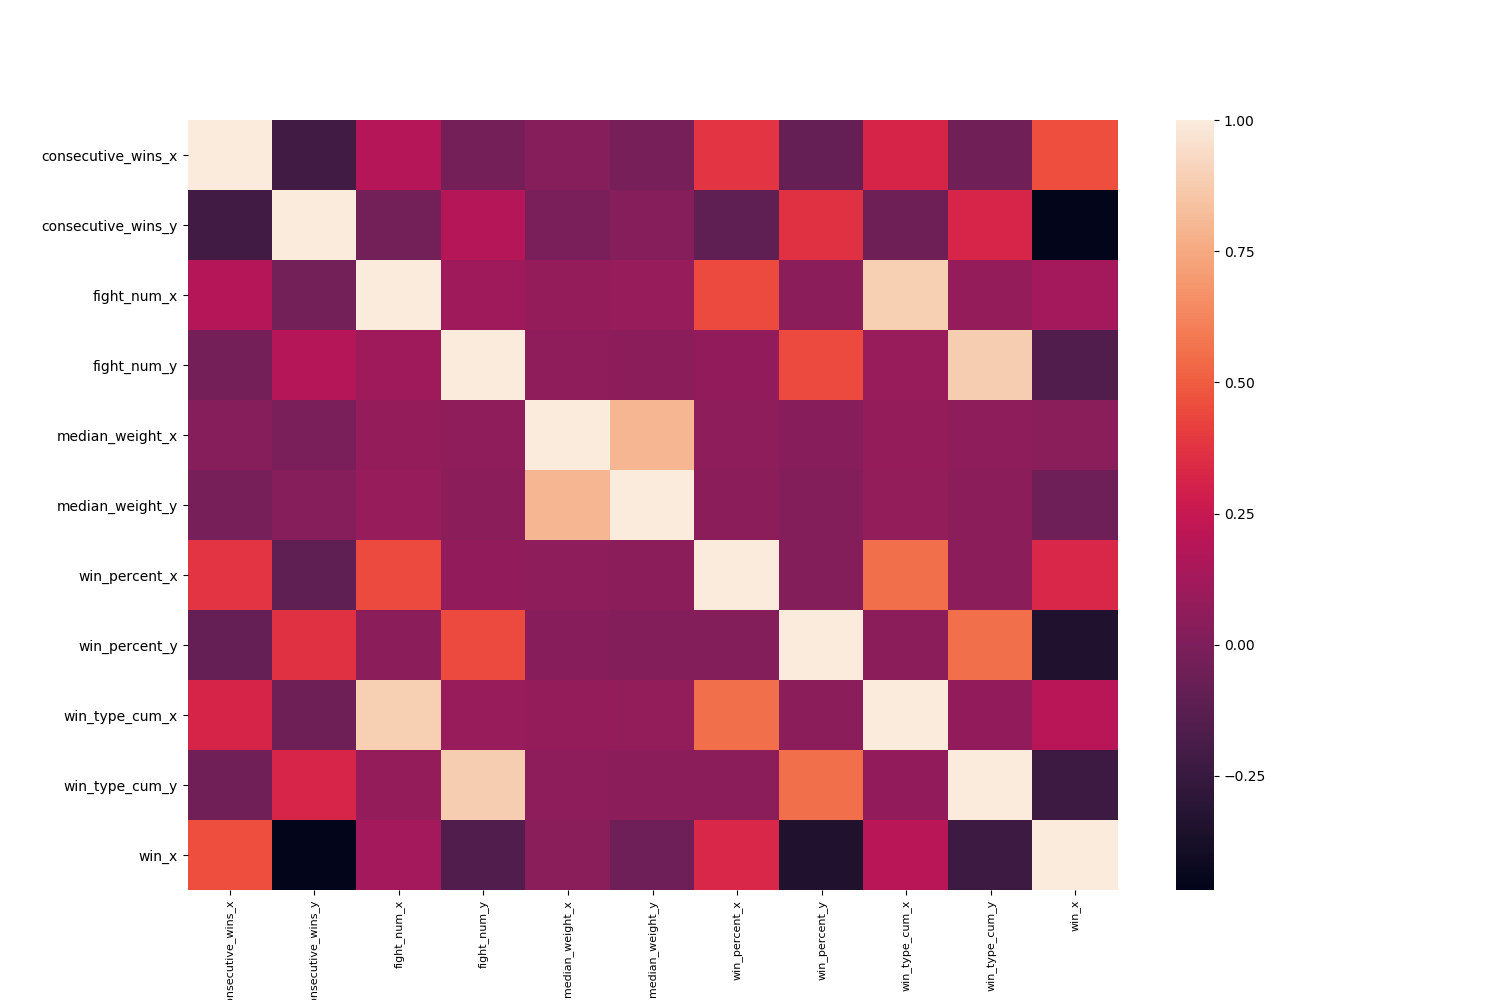

In [67]:
# Correlation Matrix
corr = df.corr()
corr = (corr)


plt.figure(figsize=(15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [32]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap

In [33]:
X = df[['consecutive_wins_x',
'consecutive_wins_y',
'fight_num_x',
'fight_num_y',
'median_weight_x',
'median_weight_y',
'win_percent_x',
'win_percent_y',
'win_type_cum_x',
'win_type_cum_y']]

y = df[['win_x']].astype(float)

In [47]:
# create train/validation split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.4, random_state=10)
dtrain = xgb.DMatrix(Xtrain, label=ytrain.values)
dtest = xgb.DMatrix(Xtest, label=ytest.values)

In [48]:
params = {
    "eta": 0.5,
    "max_depth": 6,
    "objective": "binary:logistic",
    "silent": 1,
    #"base_score": np.mean(yt.astype(float)),
    "eval_metric": "error"
}
model = xgb.train(params, dtrain, 5000, [(dtrain, "train"),(dtest, "test")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-error:0.064839	test-error:0.089258
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 5 rounds.
Stopping. Best iteration:
[2]	train-error:0.045335	test-error:0.078199



In [49]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest)

<IPython.core.display.Javascript object>


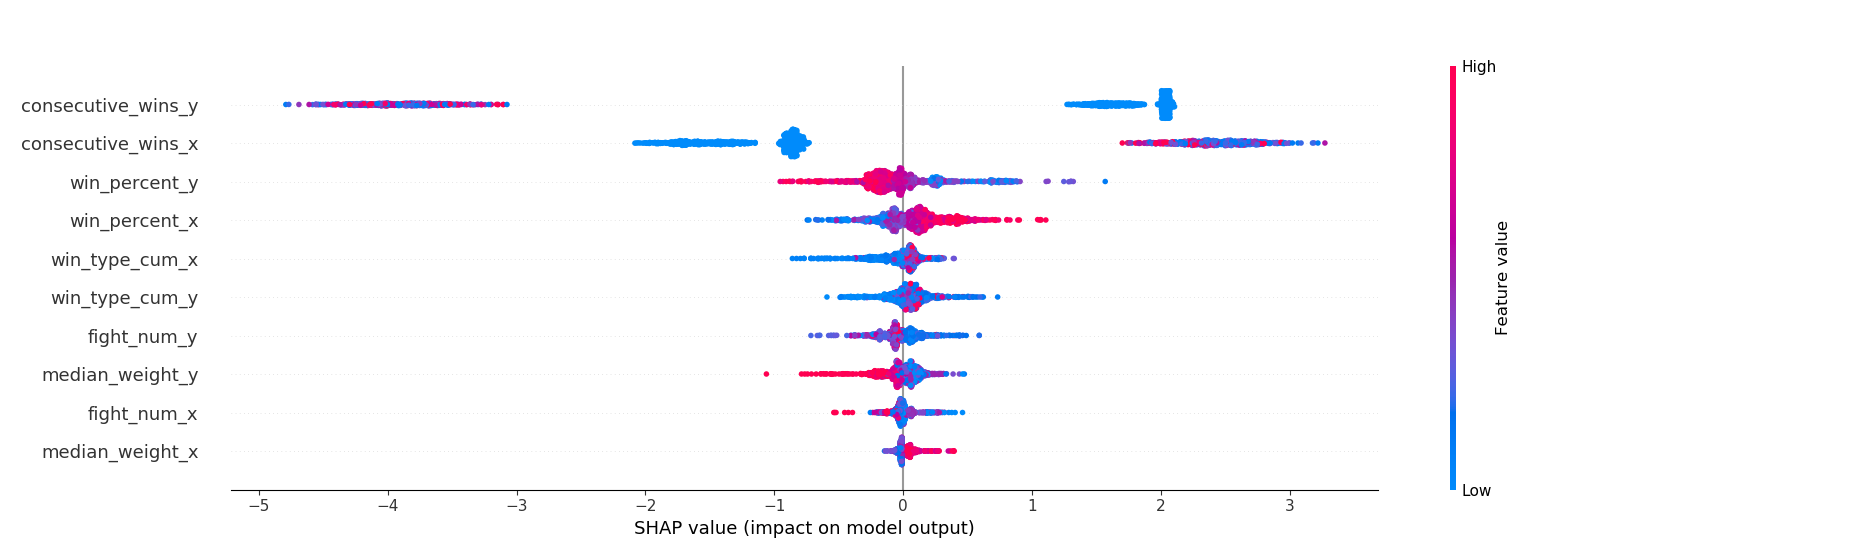

In [66]:
shap.summary_plot(shap_values, Xtest)
fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)